# Lecture 5 - Principles of Effective Visualizations

## Lecture learning goals

By the end of the lecture you will be able to:

1. Follow guidelines for best practices in visualization design.
2. Avoid overplotting via 2D distribution plots.
3. Adjust axes extents and formatting.
4. Modify titles of several figure elements.

## Readings

This lecture's readings are all from Fundamentals of Data Visualization.
They are quite short, which is why there is three of them.

- [Section 18 on overplotting](https://clauswilke.com/dataviz/overlapping-points.html)
- [Section 22 - 22.2 on titles and captions](https://clauswilke.com/dataviz/figure-titles-captions.html)
- [Section 24 on using large enough font in axis labels](https://clauswilke.com/dataviz/small-axis-labels.html)

---

In [45]:
# Run this cell to ensure that altair plots show up in the exported HTML
# and that the R cell magic works
import altair as alt

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
#alt.data_transformers.enable('data_server')
alt.data_transformers.disable_max_rows()

# Load the R cell magic
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


The schematics of many of the guidelines shown in todays were from the Cato institutes guidelines,
you can find them in full here. 
Many other guidelines are available via [this post](https://medium.com/nightingale/style-guidelines-92ebe166addc) and [this spreadsheet](https://docs.google.com/spreadsheets/d/1F1gm5QLXh3USC8ZFx_M9TXYxmD-X5JLDD0oJATRTuIE/edit#gid=1679646668). 
[The data visualization society has more interesting resources on style guidelines.](https://www.datavisualizationsociety.com/)

Another good way to learn is from other people's mistakes.
[Here the economist criticizes their own plots](https://medium.economist.com/mistakes-weve-drawn-a-few-8cdd8a42d368),
not all of them are related to concepts we teach in class,
but still worthwhile consideration to keep in mind when visualizing your data.

It is important to remember that many of these are guidelines
and there are times when you can break such guidelines,
e.g. using different colors than the good defaults
if they already have a pre-association such as for fruits, or political parties.
[This article discusses a few more cases where breaking a guideline worked well](https://medium.economist.com/why-you-sometimes-need-to-break-the-rules-in-data-viz-4d8ece284919),
although it is not always the case that they gained a lot (such as the 3D ice cubes),
at least breaking the guideline without ruining the viz,
and having something different that stands out could be important to make a visualization more memorable.

# Overplotting

In [2]:
%%R -o diamonds
# Copy diamonds df from R to Python

options(tidyverse.quiet = TRUE) 
library(tidyverse)

theme_set(theme_light(base_size = 18))

Plotting all the points in this df (there are around 50,000!) takes a little bit of time
and causes the plot to become saturated so that we can't see individual observations.

In [3]:
diamonds.shape

(53940, 10)

In [4]:
alt.Chart(diamonds).mark_point().encode(
    alt.X('carat'),
    alt.Y('price'))

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

Reducing marker size and increasing opacity only helps somewhat,
there are still many overplotted areas in the chart.

A better approach in this case is to create a 2D histogram,
where both the x and y-axes are binned which creates a binned mesh/net
over the chart area and the number of observations are counted in each bin.
Just like a histogram,
but the bins are in 2D instead of 1D.
A 2D histogram is a type of heatmap,
where count is mapped to color,
you could also have used a mark that maps size to color,
which might even be more effective
but that is not as commonly seen.

In [5]:
alt.Chart(diamonds).mark_rect().encode(
    alt.X('carat', bin=alt.Bin(maxbins=40)),
    alt.Y('price', bin=alt.Bin(maxbins=40)),
    alt.Color('count()'))

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

Here we can clearer see that a small area is much more dense than the others,
although they looked similar in the saturated plot.
How can we zoom into this area?

# ggplot

In ggplot,
there are more options for 2D distribution plots.

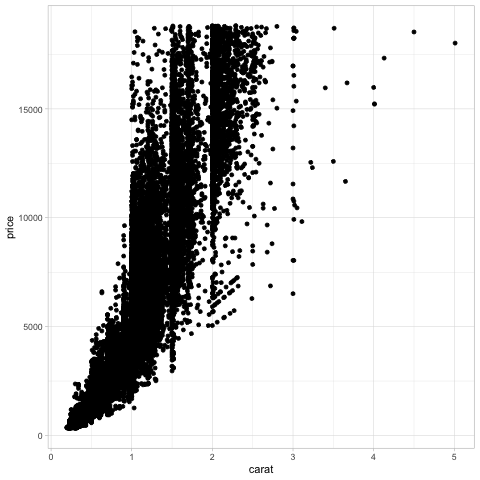

In [6]:
%%R
theme_set(theme(text = element_text(size = 18)) + theme_light())
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_point()

As with `geom_histogram`,
the binning is done by the geom,
without explicitly changing the axis like in Altair.

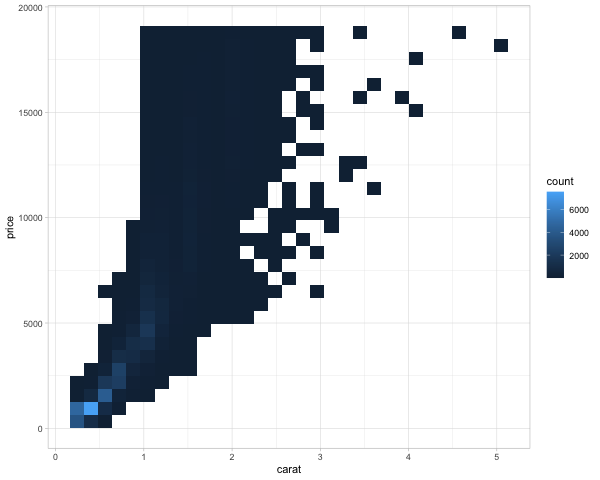

In [7]:
%%R -w 600
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_bin2d()

Instead of squares,
hexagonal bins can be used.
These have theoretically superior qualities over squares,
such as a more natural notation of neighbors
(1 step any direction instead of diagonal versus orthoganol neighbors),
and a more circular shape ensures that data points that contribute to the count of a hexagonal bin,
are not far away from the center in a corner as it could be in a square. 

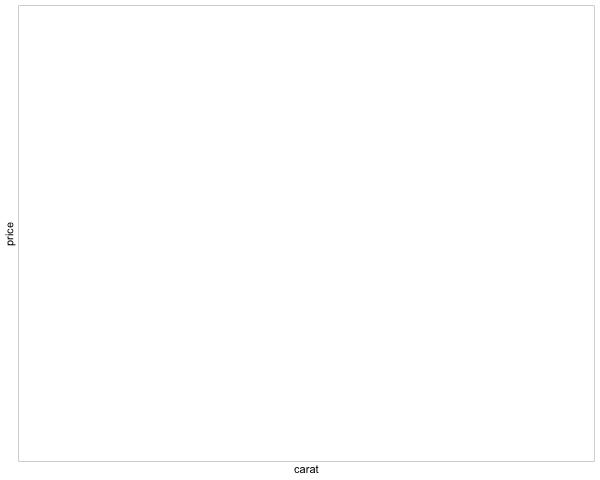

In [8]:
%%R -w 600
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex()

We can also create 2 dimensional KDEs in ggplot.
This works just like 1D KDEs,
except that the kernel on each data point
extends in 2 dimensions
(so it looks a bit like a tent)

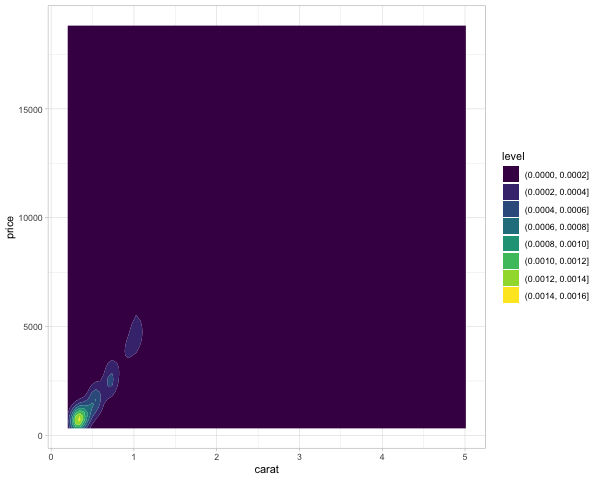

In [9]:
%%R -w 600
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_density_2d_filled()

In addition to indicate the density with color,
we could also use ridges/contours,
similar to a topographic map.
This is akin to looking at a mountain range from above, 
so small circles indicate sharp peaks.

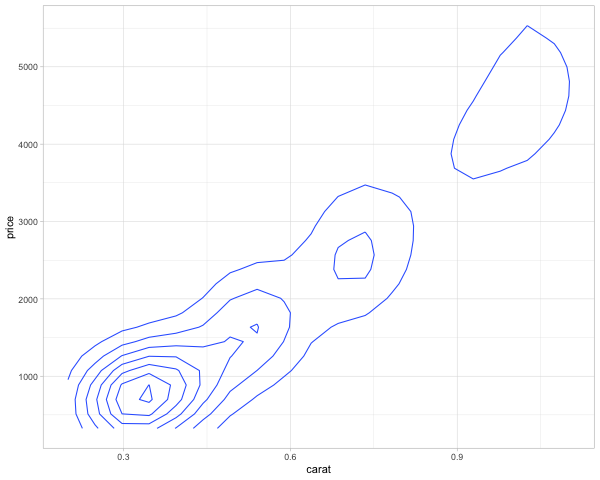

In [10]:
%%R -w 600
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_density_2d()

# Axis ranges

In many cases the most convenient way might be to filter the data before sending it to the chart.
This was you are using the efficient pandas methods to do the heavy lifting 
and avoiding slowdown from plotting many points and then zoom.

The axis range is set with the `domain` parameter to `alt.Scale`.
To set an axis range to less than the extent of the data,
we also need to include `clip=True` in the mark,
otherwise it will be plotted outside the figures.
We also need to increase the number of bins to have higher resolution in this zoomed in part.
Sometimes the range is padded with a bit of extra space automatically,
if this is undesired `nice=False` can be set inside `alt.Scale`.

All these steps should reinforce that it is usually better to filter the data
and let Altair handle the plotting.

In [11]:
# Mention filter data, clip, maxbins
alt.Chart(diamonds).mark_rect(clip=True).encode(
    alt.X('carat', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 1))),
    alt.Y('price', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 2000))),
    alt.Color('count()'))

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

Scales can be reversed.

In [12]:
# Invert
alt.Chart(diamonds).mark_rect(clip=True).encode(
    alt.X('carat', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 1))),
    alt.Y('price', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 2000), reverse=True)),
    alt.Color('count()'))

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

This is not usually that useful for an xy-axis,
but remember that color, size, etc are all scales in Altair,
so they can be reversed with the same syntax!
This is quite convenient and we will see more of it in following lectures.

In [13]:
# Invert
alt.Chart(diamonds).mark_rect(clip=True).encode(
    alt.X('carat', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 1))),
    alt.Y('price', bin=alt.Bin(maxbins=400), scale=alt.Scale(domain=(0, 2000), reverse=True)),
    alt.Color('count()', scale=alt.Scale(reverse=True)))

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

## ggplot

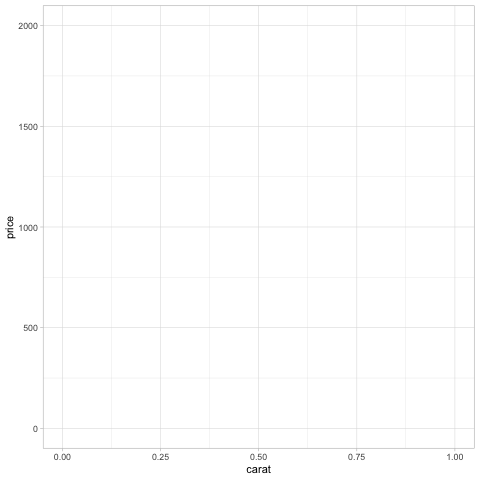

In [14]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    scale_x_continuous(limits = c(0, 1)) +
    scale_y_continuous(limits = c(0, 2000))

By deafut ggplot removes observations ouside the visible domain,
so any big marks that are both inside and outside, such as bars for example,
will be cut out.
This is good because it makes it hard for people to make poor visualization choices,
such as zooming in on bar charts instead of showin the entire domain starting from zero.
In situation where you do need to include such partial graphics,
you can set the out of bounds (`oob`) parameter to `scales::oob_keep`
as described in https://scales.r-lib.org/reference/oob.html.

You can see that there is a bit of empty space or padding on each size of the x-axis
to the left of 0 and to the right of 1.
If we want to get rid of this,
we can set `expand = expansion(mult = c(0, 0)))` in the scale we're using.
The vector contains the min and max padding and changes as a multiplication of the current axis range. 
So if we wanted some space at the right side, 
we could use `mult = c(0, 0.05))` or similar instead.
[More details here](https://stackoverflow.com/questions/44170871/how-does-ggplot-scale-continuous-expand-argument-work#44170954).

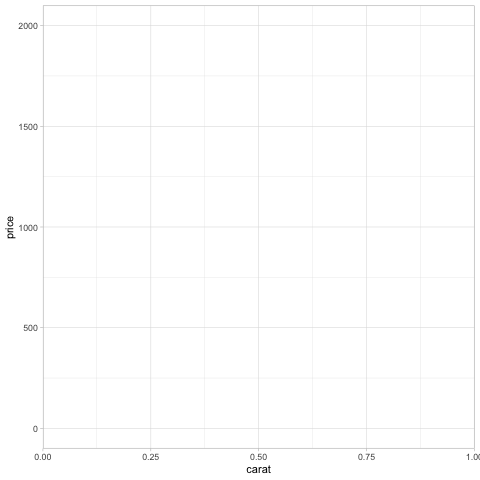

In [15]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    scale_x_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0))) +
    scale_y_continuous(limits = c(0, 2000))

To reverse the axis,
we can set `trans = 'reverse'`.
Other transforms include `log10` which there is also a shortcut for `scale_x_log10`.
We also need to set the limits to go the opposite direction.

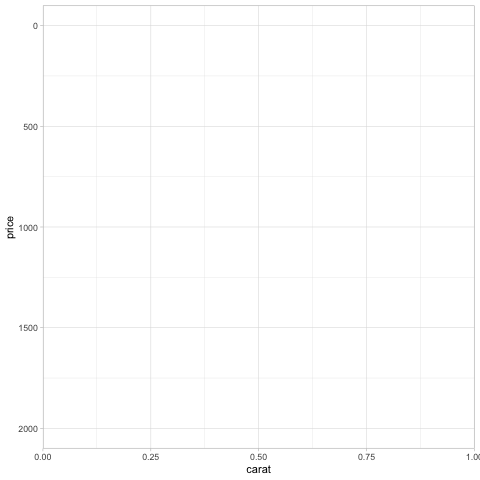

In [16]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    scale_x_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0))) +
    scale_y_continuous(limits = c(2000, 0), trans = 'reverse')

Just as in Altair,
color scales can be controlled the same way as axis scales
(the color for the hexagons is set via `fill` rather than `color`).

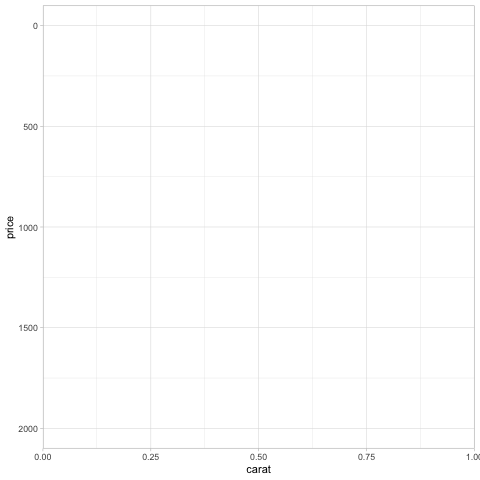

In [17]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    scale_x_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0))) +
    scale_y_continuous(limits = c(2000, 0), trans = 'reverse') +
    scale_fill_continuous(trans = 'reverse')

# Axis label formatting

[All labels formats can be found here](https://github.com/d3/d3-format#locale_format). Notable ones include `%`, `$`, `e`, `s`.

In [18]:
# Remove the bins and take a sample of the code make the code clearer
diamonds = diamonds.sample(1000, random_state=1010)

Scientific notation (`10^` or `e+`) can be useful internally,
but can be confusing for communicating to a more general audience.

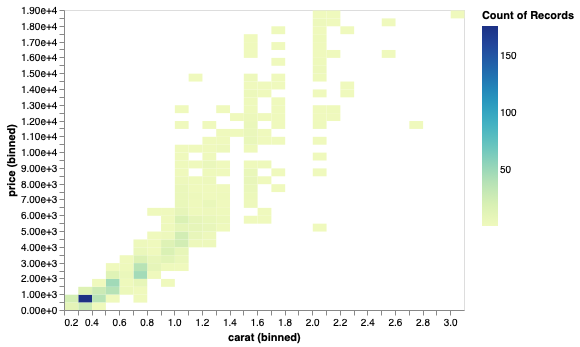

In [19]:
alt.Chart(diamonds).mark_rect().encode(
    alt.X('carat', bin=alt.Bin(maxbins=40)),
    alt.Y('price', bin=alt.Bin(maxbins=40), axis=alt.Axis(format='e')),
    alt.Color('count()'))

Standard international (SI) units are often easier to digest.

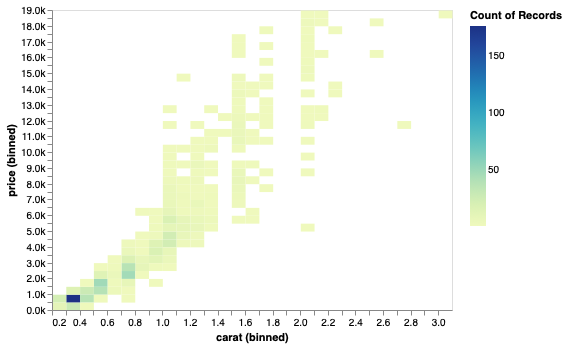

In [20]:
alt.Chart(diamonds).mark_rect().encode(
    alt.X('carat', bin=alt.Bin(maxbins=40)),
    alt.Y('price', bin=alt.Bin(maxbins=40), axis=alt.Axis(format='s')),
    alt.Color('count()'))

A prefaced `~` removes trailing zeros.

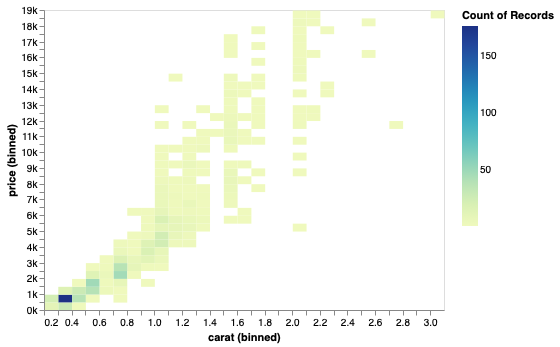

In [21]:
alt.Chart(diamonds).mark_rect().encode(
    alt.X('carat', bin=alt.Bin(maxbins=40)),
    alt.Y('price', bin=alt.Bin(maxbins=40), axis=alt.Axis(format='~s')),
    alt.Color('count()'))

Formaters can also be combined.

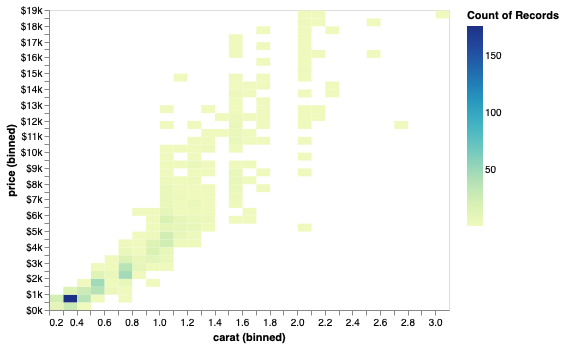

In [22]:
alt.Chart(diamonds).mark_rect().encode(
    alt.X('carat', bin=alt.Bin(maxbins=40)),
    alt.Y('price', bin=alt.Bin(maxbins=40), axis=alt.Axis(format='$~s')),
    alt.Color('count()'))

The same format keys can be used for the legend.

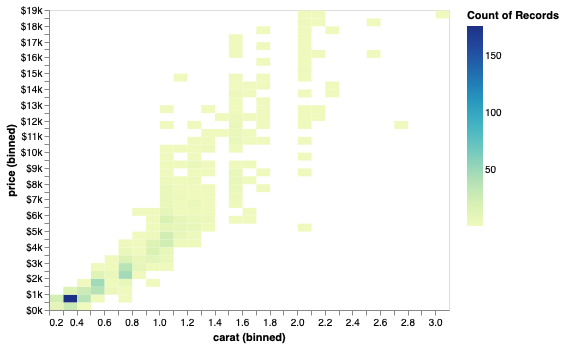

In [23]:
alt.Chart(diamonds).mark_rect().encode(
    alt.X('carat', bin=alt.Bin(maxbins=40)),
    alt.Y('price', bin=alt.Bin(maxbins=40), axis=alt.Axis(format='$~s')),
    alt.Color('count()', legend=alt.Legend(format='s')))

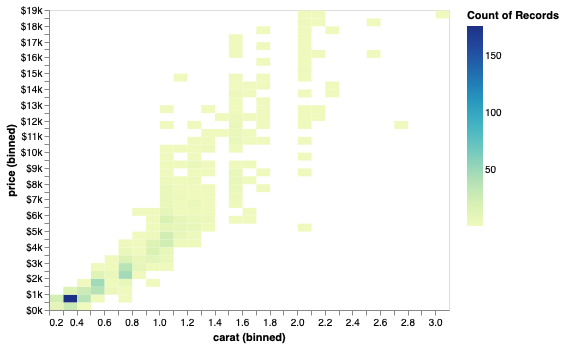

In [24]:
alt.Chart(diamonds).mark_rect().encode(
    alt.X('carat', bin=alt.Bin(maxbins=40)),
    alt.Y('price', bin=alt.Bin(maxbins=40), axis=alt.Axis(format='$~s', tickCount=1)),
    alt.Color('count()', legend=alt.Legend(format='s')))

The number of ticks can be modified via `tickCount`,
but not for binned data.

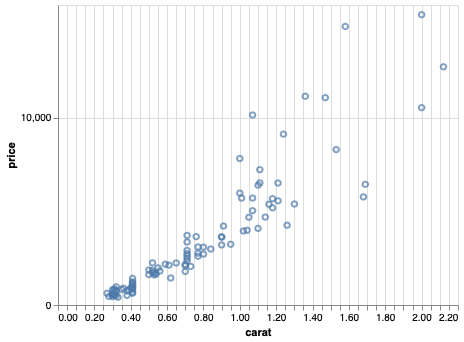

In [25]:
alt.Chart(diamonds.sample(100)).mark_point().encode(
    alt.X('carat', axis=alt.Axis(tickCount=40)),
    alt.Y('price', axis=alt.Axis(tickCount=2)))

You can also remove an axis altogether.

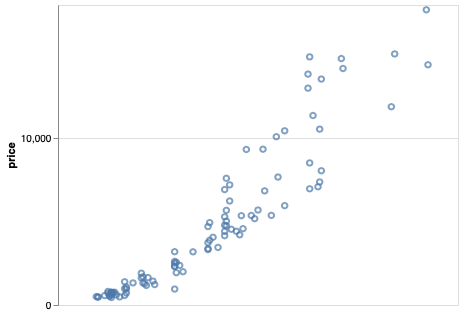

In [26]:
alt.Chart(diamonds.sample(100)).mark_point().encode(
    alt.X('carat', axis=None),
    alt.Y('price', axis=alt.Axis(tickCount=2)))

And set a different theme.

In [27]:
alt.themes.names()

['dark',
 'default',
 'fivethirtyeight',
 'ggplot2',
 'latimes',
 'none',
 'opaque',
 'quartz',
 'urbaninstitute',
 'vox']

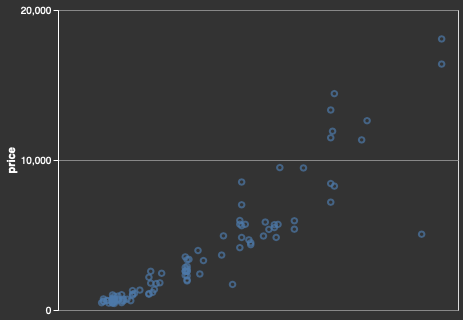

In [28]:
alt.themes.enable('dark')
alt.Chart(diamonds.sample(100)).mark_point().encode(
    alt.X('carat', axis=None),
    alt.Y('price', axis=alt.Axis(tickCount=2)))

## ggplot

The `scales` package helps with the formatting in ggplot.

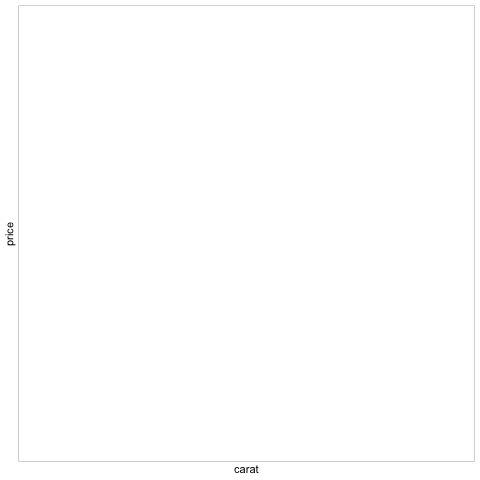

In [29]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    scale_y_continuous(labels = scales::label_scientific())

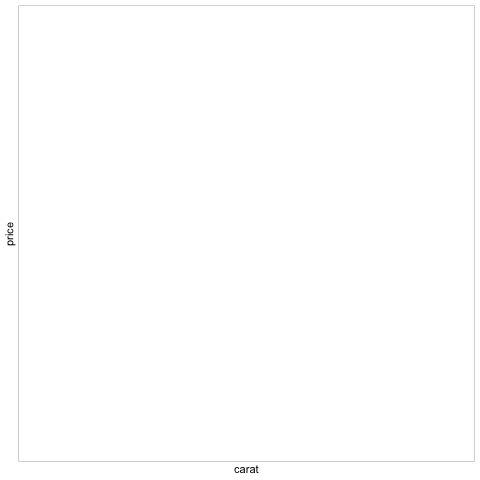

In [30]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    scale_y_continuous(labels = scales::label_number_si())

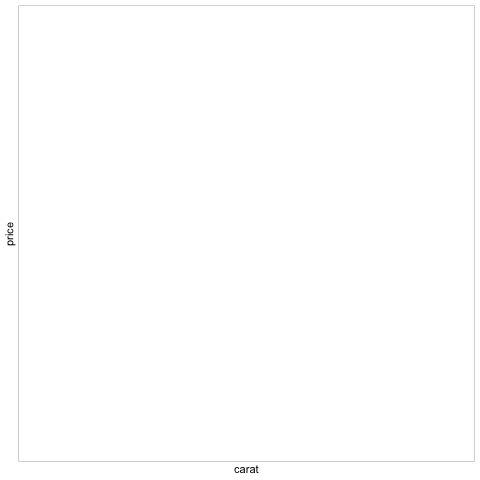

In [31]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    scale_y_continuous(labels = scales::label_dollar())

The legend can be formatted via the same syntax.

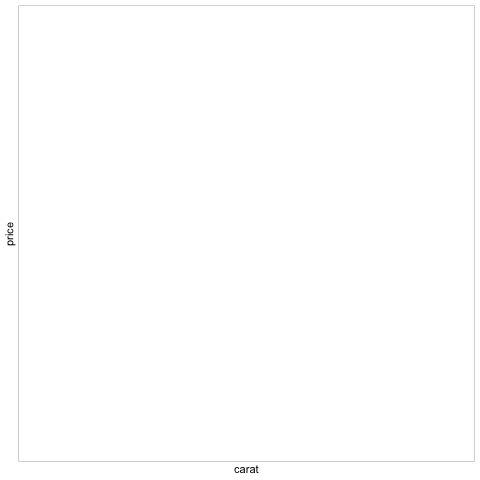

In [32]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    scale_y_continuous(labels = scales::label_dollar()) +
    scale_fill_continuous(labels = scales::label_number_si())

The scales package also helps us setting the number of ticks (breaks) on an axis.

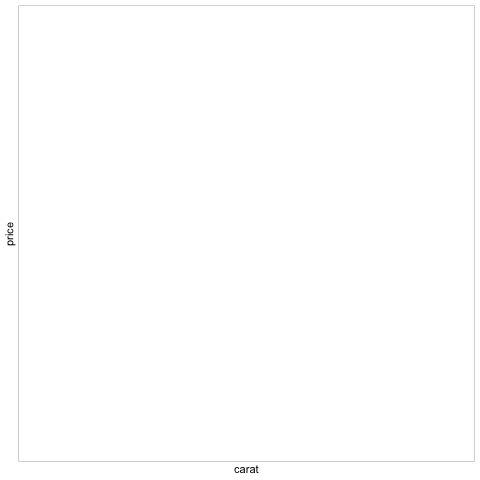

In [33]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    scale_y_continuous(
        labels = scales::label_dollar(),
        breaks = scales::pretty_breaks(n = 10)) +
    scale_fill_continuous(labels = scales::label_number_si())

You can remove an axis.

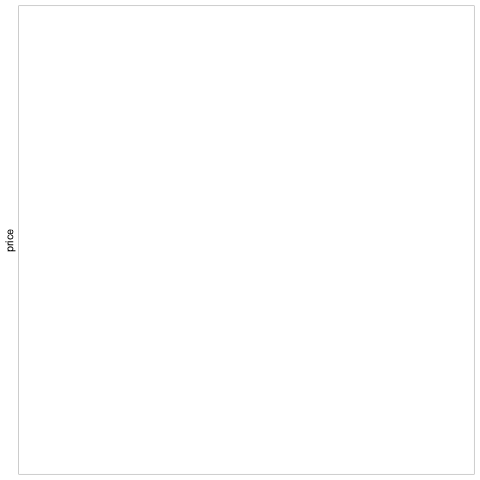

In [34]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank())

Or set a theme that hides all axis objects.

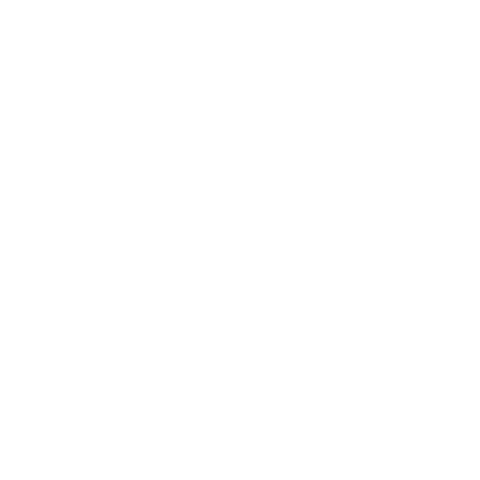

In [35]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    theme_void()

The classic theme is nice.
There are [many more sophisticated theme in the ggthemes](https://mran.microsoft.com/snapshot/2016-12-03/web/packages/ggthemes/vignettes/ggthemes.html).

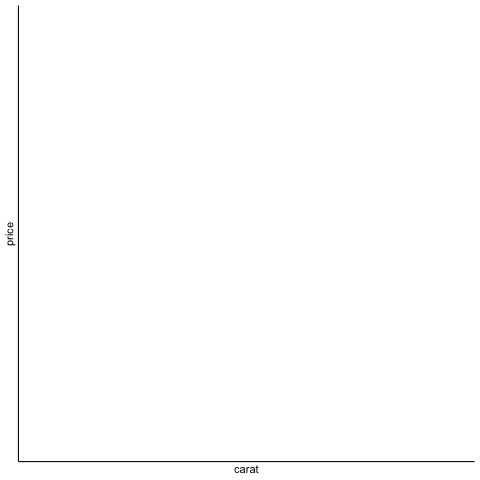

In [36]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    theme_classic()

# Figure, axis, and legend titles

When doing EDA, axis titles etc don't matter that much,
since you are the primary person interpreting them.
In communication however,
your plots often need to be interpretable on their own
without explanation.
Setting descriptive titles is a big part of this,
please see the required readings for more info.

Axis titles should be capitalized and contain spaces,
no variable names with underscores.

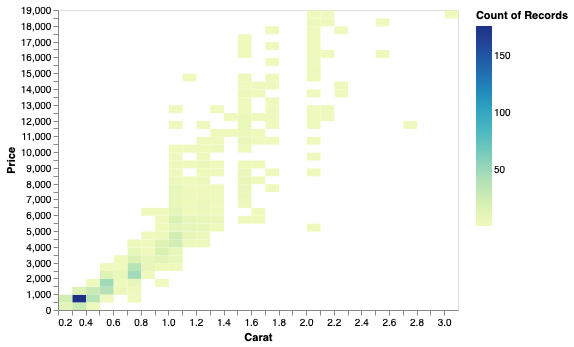

In [37]:
# Set back to defaut theme
alt.themes.enable('default')
alt.Chart(diamonds).mark_rect().encode(
    alt.X('carat', bin=alt.Bin(maxbins=40), title='Carat'),
    alt.Y('price', bin=alt.Bin(maxbins=40), title='Price'),
    color='count()')

The legend title is controlled inside the encoding channel that is displays.

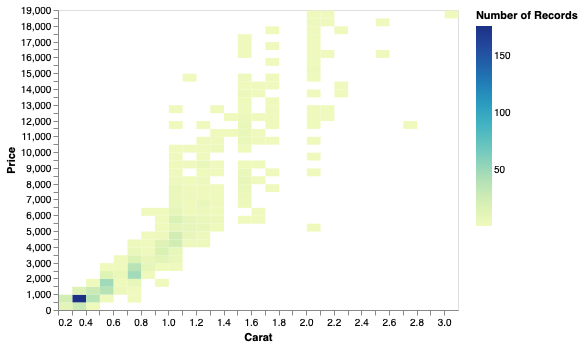

In [38]:
alt.Chart(diamonds).mark_rect().encode(
    alt.X('carat', bin=alt.Bin(maxbins=40), title='Carat'),
    alt.Y('price', bin=alt.Bin(maxbins=40), title='Price'),
    alt.Color('count()', title='Number of Records'))

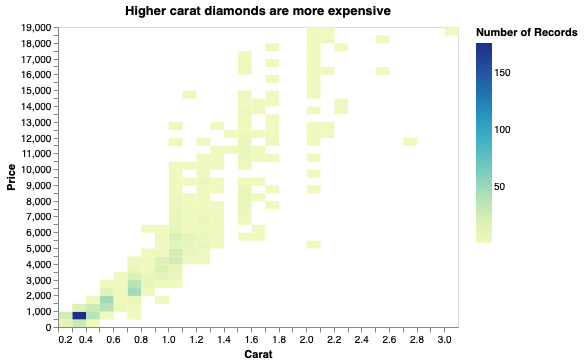

In [39]:
alt.Chart(diamonds, title='Higher carat diamonds are more expensive').mark_rect().encode(
    alt.X('carat', bin=alt.Bin(maxbins=40), title='Carat'), 
    alt.Y('price', bin=alt.Bin(maxbins=40), title='Price'),
    alt.Color('count()', title='Number of Records'))

A suptitle is a property of a title.

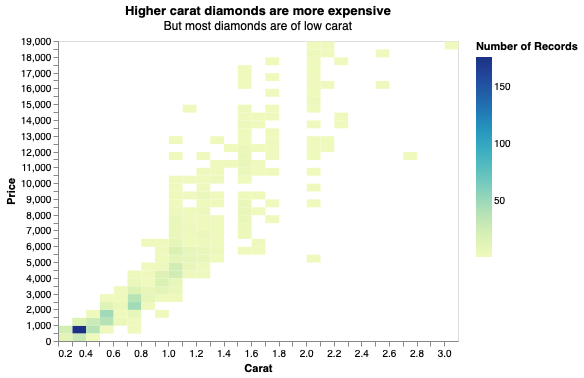

In [40]:
(alt.Chart(
    diamonds,
    title=alt.TitleParams(
        text='Higher carat diamonds are more expensive',
        subtitle='But most diamonds are of low carat'))
 .mark_rect().encode(
    alt.X('carat', bin=alt.Bin(maxbins=40), title='Carat'), 
    alt.Y('price', bin=alt.Bin(maxbins=40), title='Price'),
    alt.Color('count()', title='Number of Records')))

## ggplot

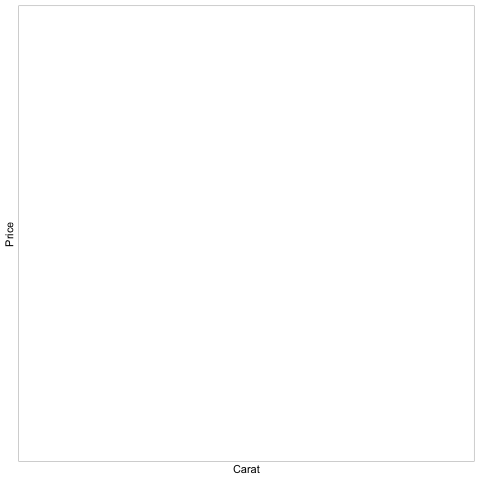

In [41]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    labs(x = 'Carat', y = 'Price')

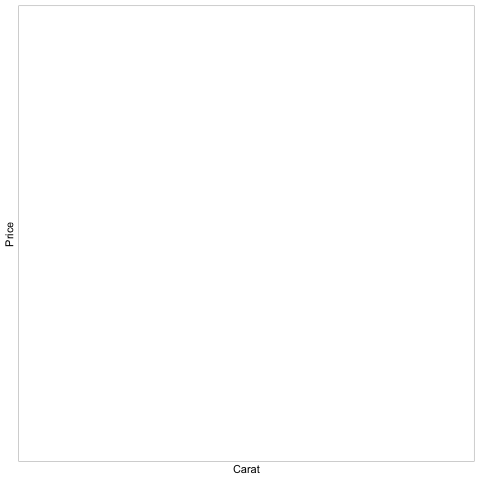

In [42]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    labs(x = 'Carat', y = 'Price', fill = 'Number')

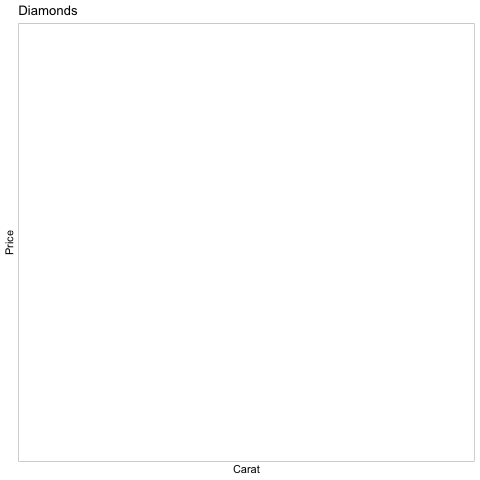

In [43]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    labs(x = 'Carat', y = 'Price', fill = 'Number', title = 'Diamonds') +
    scale_y_continuous(labels = scales::label_dollar())

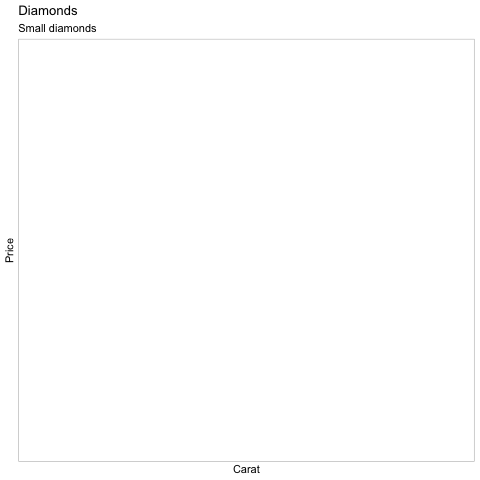

In [44]:
%%R
ggplot(diamonds) +
    aes(x = carat,
        y = price) +
    geom_hex() +
    labs(x = 'Carat', y = 'Price', fill = 'Number', title = 'Diamonds', subtitle='Small diamonds') +
    scale_y_continuous(labels = scales::label_dollar())